In [ ]:
!pip install tensorflow

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model


img_A_inp = Input((28, 28), name='img_A_inp')
img_B_inp = Input((28, 28), name='img_B_inp')

def get_cnn_block(depth):
  return Sequential([Conv2D(depth, 3, 1),
                     BatchNormalization(),
                     ReLU()])

DEPTH = 64
cnn = Sequential([Reshape((28, 28, 1)),
                  get_cnn_block(DEPTH),
                  get_cnn_block(DEPTH*2),
                  get_cnn_block(DEPTH*4),
                  get_cnn_block(DEPTH*8),
                  GlobalAveragePooling2D(),
                  Dense(64, activation='relu')])

feature_vector_A = cnn(img_A_inp)
feature_vector_B = cnn(img_B_inp)

concat = Concatenate()([feature_vector_A, feature_vector_B])

dense = Dense(64, activation='relu')(concat)
output = Dense(1, activation='sigmoid')(dense)

model = Model(inputs=[img_A_inp, img_B_inp], outputs=output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 img_A_inp (InputLayer)      [(None, 28, 28)]             0         []                            
                                                                                                  
 img_B_inp (InputLayer)      [(None, 28, 28)]             0         []                            
                                                                                                  
 sequential_4 (Sequential)   (None, 64)                   1586496   ['img_A_inp[0][0]',           
                                                                     'img_B_inp[0][0]']           
                                                                                                  
 concatenate (Concatenate)   (None, 128)                  0         ['sequential_4[0][0]',    

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/'


Mounted at /content/drive
/content/drive/MyDrive


In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
# Define the paths to your image folders
hat_folder = "./Data/Hats"
shirt_folder = "./Data/Shirts"
hoodie_folder = "./Data/Hoodies"

# Define the target size for resizing images
target_size = (28, 28)

In [ ]:
# Load and preprocess the images from each category
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith(".png"):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
            img = cv2.resize(img, target_size)  # Resize to target size
            img = img / 255.0  # Normalize pixel values to [0, 1]
            images.append(img)
            labels.append(label)
    return images, labels

In [ ]:
hat_images, hat_labels = load_images_from_folder(hat_folder, label=0)  # Label 0 for hats
shirt_images, shirt_labels = load_images_from_folder(shirt_folder, label=1)  # Label 1 for shirts
hoodie_images, hoodie_labels = load_images_from_folder(hoodie_folder, label=2)  # Label 2 for hoodies


In [ ]:
# Combine data and labels for all categories
images = np.array(hat_images + shirt_images + hoodie_images)
labels = np.array(hat_labels + shirt_labels + hoodie_labels)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=42)


In [ ]:
# Create pairs of images and their labels (0 for dissimilar, 1 for similar)
def create_image_pairs(X, y):
    pairs, pair_labels = [], []
    for i in range(len(X)):
      for j in range(i+1, len(X)):
        img1, img2 = X[i], X[j]
        if y[i] == y[j]:  # Similar images
            pair_labels.append(1)
        else:  # Dissimilar images
            pair_labels.append(0)
        pairs.append([img1, img2])

    return np.array(pairs), np.array(pair_labels)

In [ ]:
X_train_pairs, y_train_pairs = create_image_pairs(X_train, y_train)
X_test_pairs, y_test_pairs = create_image_pairs(X_test, y_test)
X_train_pairs.shape, y_train_pairs.shape

((1431, 2, 28, 28), (1431,))

In [ ]:
import tensorflow as tf

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=3)

In [ ]:
model.fit(x=[X_train_pairs[:, 0, :, :], X_train_pairs[:, 1, :, :]],
          y=y_train_pairs,
          validation_data=([X_test_pairs[:, 0, :, :],
                            X_test_pairs[:, 1, :, :]],
                           y_test_pairs),
          epochs=1000,
          batch_size=32,
          callbacks=[es])

Epoch 1/1000
45/45 [==============================] - 2s 48ms/step - loss: 0.0215 - accuracy: 0.9944 - val_loss: 2.6491 - val_accuracy: 0.2667
Epoch 2/1000
45/45 [==============================] - 2s 47ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 1.0140 - val_accuracy: 0.8667
Epoch 3/1000
45/45 [==============================] - 2s 50ms/step - loss: 0.0032 - accuracy: 0.9993 - val_loss: 0.2599 - val_accuracy: 0.8667
Epoch 4/1000
45/45 [==============================] - 2s 50ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 5/1000
45/45 [==============================] - 2s 49ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 6/1000
45/45 [==============================] - 2s 47ms/step - loss: 6.4802e-04 - accuracy: 1.0000 - val_loss: 6.3953e-04 - val_accuracy: 1.0000
Epoch 7/1000
45/45 [==============================] - 2s 47ms/step - loss: 4.8925e-04 - accuracy: 1.0000 - val_loss: 5.4848e-04 - val_

In [ ]:
img_A, img_B = X_test[3], X_test[4]

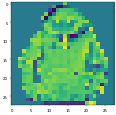

In [ ]:
import matplotlib.pyplot as plt

plt.figure(dpi=28)
plt.imshow(img_A)

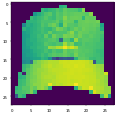

In [ ]:
import matplotlib.pyplot as plt

plt.figure(dpi=28)
plt.imshow(img_B)

In [ ]:
model.predict([img_A.reshape((1, 28, 28)),
               img_B.reshape((1, 28, 28))]).flatten()[0]

1/1 [==============================] - 0s 19ms/step


8.162846e-05